# Begin

In [1]:
## installing some packages
!pip install mlxtend==0.17
!pip install -U keras-tuner


  Using cached mlxtend-0.17.0-py2.py3-none-any.whl (1.3 MB)
  Using cached scipy-1.5.4-cp38-cp38-win32.whl (28.4 MB)
  Using cached numpy-1.19.4-cp38-cp38-win32.whl (11.0 MB)
  Using cached matplotlib-3.3.3-cp38-cp38-win32.whl (8.3 MB)


You should consider upgrading via the 'c:\users\nam4.nguyen\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\nam4.nguyen\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.



Using legacy setup.py install for keras-tuner, since package 'wheel' is not installed.
Using legacy setup.py install for future, since package 'wheel' is not installed.
Using legacy setup.py install for terminaltables, since package 'wheel' is not installed.
    Running setup.py install for future: started
    Running setup.py install for future: finished with status 'done'
    Running setup.py install for terminaltables: started
    Running setup.py install for terminaltables: finished with status 'done'
    Running setup.py install for keras-tuner: started
    Running setup.py install for keras-tuner: finished with status 'done'


In [1]:
## for using google colab, no need to run if not using colab.
from google.colab import drive
drive.mount('/content/drive')

cd /content/drive/My Drive/Projects/Emotion Recognition/neural setA


SyntaxError: invalid syntax (<ipython-input-1-6a142af4f67b>, line 5)

# Code starts here

In [1]:
# save dir
import os
root = os.getcwd()
print(root)

import numpy as np
import scipy

from scipy import signal
from scipy.signal import find_peaks, convolve
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

emotion_keys = ["No Emotion", "Anger", "Hate", "Grief","P-Love", "R-Love","Joy", "Reverence"]

results_fold = "results/7s-overlapping"
fold_dir = os.path.join(root, results_fold)
print(fold_dir)

E:\TriMun\src
E:\TriMun\src\results/7s-overlapping


In [2]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize = False,
                          savefig = False,
                          figname = "confusion_matrix.png"):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    savefig:      If False, do not save the figure
                  If True, plot the figure with the given name defined by figname argument
    figname:      name of the figure to save

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    height, width = cm.shape
    offset = 0.5
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    plt.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    cmn = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize == True:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        elif normalize == False:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}\n {:0.2f} %".format(cm[i, j], cmn[i, j]),
                     horizontalalignment="center",
                     verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label\naccuracy={:0.2f} %; misclass={:0.2f} %'.format(100*accuracy, 100*misclass))

    if savefig:
        plt.savefig(figname, bbox_inches = "tight")
        print("saved image to drive")
    plt.show()

In [3]:
def segmenting_overlapping(data, slice_length = 10, overlap = 7, sampling_rate = 20):
    # function to segment 1d vector signal
    # data: all data -shape (N, channels, signal_length)
    # slice_length: length of the slice in seconds
    # overlap: length of the overlapping in seconds
    # sampling_rate: sampling rate of the signal
    segmented_data = []
    data_shape = data.shape
    len_signal = data_shape[2]
    len_std = sampling_rate * slice_length
    for sset in data:
        segmented_set = []
        for signal in sset:
            segments_list = []
            
            slices = np.arange(0, int(len_signal/sampling_rate)+1, slice_length-overlap, dtype=np.int) # 26 is arbitrary
            # print(slices)
            for start, end in zip(slices[:-1], slices[1:]):
                start_segment = start * sampling_rate
                end_segment = min((end + overlap)*sampling_rate, len_signal) 
#                 print(start_audio, end_audio)
                if end_segment-start_segment == len_std:
                    segments_list.append(signal[start_segment:end_segment])
            segmented_set.append(segments_list)
            segments_list = []
        segmented_data.append(segmented_set)
        segmented_set = []
    segmented_data = np.array(segmented_data)
    return segmented_data

# features extraction

In [5]:
# Extract features from signals

class Function(object):
    """Wraper class for funcions"""

    def __init__(self, func, description="Simple function", fun_type='transform'):
        self.func = func
        self.description = description
        self.func_type = fun_type

    def __call__(self, data):
        return self.func(data)

    def __repr__(self):
        return self.func_type + ":" + self.description
    
    ## statistical features
    def calculate_statistics(self, signal):
        # signal = signal.reshape((-1, 1))
        mean = np.nanmean(signal)
        median = np.median(signal, axis = 0)
        maximum = np.max(signal, axis = 0)
        minimum = np.min(signal, axis = 0)
        std = np.std(signal, axis = 0)
        variance = np.var(signal, axis = 0)
        _range = np.ptp(signal, axis = 0)
        skewness = scipy.stats.skew(signal, axis = 0)
        kurtosis = scipy.stats.kurtosis(signal, axis = 0)
        
        return [mean, median, maximum, minimum, std, variance, _range, skewness, kurtosis]

    def difference_absolute_values_mean(self, signal, different_num, round_number = 2):
        value = 0
        for i in range(len(signal)- different_num):
            value += abs(signal[i+different_num] - signal[i])
        mean_value = round(value/(len(signal) - different_num), round_number )

        return mean_value


    def normalize_zeromean_variance(self, signal, mean, std):
        normalized_signal = (signal - mean)/(std + np.finfo(float).eps)

        return normalized_signal
    
    def normalize_signal(self, signal):
        mean, std = np.nanmean(signal), np.nanstd(signal)
        normalized_signal = self.normalize_zeromean_variance(signal, mean, std)
        
        return normalized_signal
    
#     def BVP_features(signal):

class FeatureExtractor(Function):
    def __init__(self):
        fnc = Function(self)
        # self.all_data = all_data
        self.features_list = []


    def fit(self, all_data):
        print(all_data.shape)
        # assert self.all_data.shape[2] > self.all_data.shape[1], "data shape must be (N, channels, data)" 
        for signal_set in all_data:
            features = []
            for signal in signal_set:

                statistic_features = self.calculate_statistics(signal)
                first_diff_mean = self.difference_absolute_values_mean(signal,1)
                second_diff_mean = self.difference_absolute_values_mean(signal, 2)
                normalized_signal = self.normalize_signal(signal)
                first_diff_mean_normalized = self.difference_absolute_values_mean(normalized_signal, 1)
                second_diff_mean_normalized = self.difference_absolute_values_mean(normalized_signal, 2)

                features += statistic_features
                features.append(first_diff_mean)
                features.append(second_diff_mean)
                features.append(first_diff_mean_normalized)
                features.append(second_diff_mean_normalized)        

            self.features_list.append(features)
        return np.array(self.features_list)

In [6]:
# load data
data = np.load("data.npy")
print(data.shape)
labels  = np.load("labels.npy")
labels_number = np.ndarray((160))

# EMG = data[:, :, 0]
# BVP = data[:, :, 1]
# GSR = data[:, :, 2]
# RES = data[:, :, 3]
for i,key in enumerate(emotion_keys):
    labels_number[np.where(labels == key)] = i

# cut original data to segments using segmententing_overlapping function
slice_length = 10 # length of the segment = 10s
sampling_rate = 20 # sampling rate of raw signal
overlap = 0 # overlapping ratio percentage

data_cut = segmenting_overlapping(np.transpose(data, (0, 2, 1)), slice_length = slice_length, overlap = overlap, sampling_rate = sampling_rate)    
print("Data_cut", data_cut.shape)

## transpose to get (160, 31, 4, 200) - (N_samples, N_segments, N_channels, segment_length) 
datax = np.transpose(data_cut, (0, 2, 1, 3))
print("Datax", datax.shape)
## generate labels
y = np.zeros((20, datax.shape[1]))
labelx = y
for i in range(1,8):
    labelx = np.concatenate((labelx, y+i))

# reshape to get data in the expected form (N_samples * N_segments, N_channels, segment_length)
# each segment is now considered as a new sample. 
dataxx = np.reshape(datax, (-1, 4, datax.shape[3]))
print("Dataxx", dataxx.shape)
labelxx = np.reshape(labelx, (-1))
print("Labelxx", labelxx.shape)
print(len(list(np.where(labelxx==7))[0]))

# Extracting features
feature_list = FeatureExtractor().fit(dataxx)
print("Feature", feature_list.shape)

# feature_list_original = FeatureExtractor().fit(np.transpose(data, (0, 2, 1)))
# y_test_original = labels_number

# save features
np.save("Feature data/features_" + str(overlap) + "s.npy", feature_list)
np.save("Label/" + str(overlap) + "sec_labels.npy", labelxx)

(160, 2001, 4)
Data_cut (160, 4, 10, 200)
Datax (160, 10, 4, 200)
Dataxx (1600, 4, 200)
Labelxx (1600,)
200
(1600, 4, 200)
Feature (1600, 52)


# Split data

In [7]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.model_selection import LeaveOneOut,  KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import pandas as pd

In [20]:
overlap = 9
feature_list = np.load("Feature data/features_" + str(overlap) + "s.npy")
labelxx = np.load("Label/" + str(overlap) + "sec_labels.npy")
len_data = dataxx.shape[2]
print(feature_list.shape)
print(len_data)

next_day = (int)(labelxx.shape[0]/160)
emo_step = (int)(labelxx.shape[0]/8)
seg = (int)(next_day/2)
no_sample = 1
no_exclude = (int)((len_data - 1)/(len_data - overlap*len_data/10))
print("No exclude ", no_exclude)

X_features_train = feature_list[0:1]
X_features_test = feature_list[0:1]
y_train = labelxx[0:1]
y_test = labelxx[0:1]
for i in range(0, 8):
    for j in range(0, 20):
        X_features_train = np.concatenate((X_features_train, feature_list[emo_step*i + next_day*j: emo_step*i + next_day*j + seg - no_exclude]))
        X_features_test = np.concatenate((X_features_test, feature_list[emo_step*i + next_day*j + seg: emo_step*i + next_day*j + seg + no_sample]))
#         X_features_train = np.concatenate((X_features_train, feature_list[emo_step*i + next_day*j + seg + no_sample: emo_step*i + next_day*j + next_day]))     
        X_features_train = np.concatenate((X_features_train, feature_list[emo_step*i + next_day*j + seg + no_sample + no_exclude: emo_step*i + next_day*j + next_day]))
        
        y_train = np.concatenate((y_train, labelxx[emo_step*i + next_day*j: emo_step*i + next_day*j + seg - no_exclude]))
        y_test = np.concatenate((y_test, labelxx[emo_step*i + next_day*j + seg: emo_step*i + next_day*j + seg + no_sample]))
#         y_train = np.concatenate((y_train, labelxx[emo_step*i + next_day*j + seg + no_sample: emo_step*i + next_day*j + next_day]))
        y_train = np.concatenate((y_train, labelxx[emo_step*i + next_day*j + seg + no_sample + no_exclude: emo_step*i + next_day*j + next_day]))

#         X_features_train = np.concatenate((X_features_train, feature_list[emo_step*i + next_day*j + seg + 2: emo_step*i + next_day*j + next_day]))
#         X_features_test = np.concatenate((X_features_test, feature_list[emo_step*i + next_day*j : emo_step*i + next_day*j + seg]))
#         y_train = np.concatenate((y_train, labelxx[emo_step*i + next_day*j + seg + 2: emo_step*i + next_day*j + next_day]))
#         y_test = np.concatenate((y_test, labelxx[emo_step*i + next_day*j : emo_step*i + next_day*j + seg]))

X_features_train = X_features_train[1:]
X_features_test = X_features_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]
# standardize data
sc = StandardScaler()
sc.fit(X_features_train)
X_features_train, X_features_test = sc.transform(X_features_train), sc.transform(X_features_test)

print("Number of train samples: ", X_features_train.shape[0])
print("Number of test samples: ", X_features_test.shape[0])

(14560, 52)
200
No exclude  9
Number of train samples:  11520
Number of test samples:  160


In [ ]:
# check whether the data contains nan or infinity values
print(np.where(np.isinf(X_features_train)))

na = np.where(np.isnan(X_features_train))
print(na)
for i in na:
    print(i)
    print(np.where(np.isnan(X_features_train[i])))

In [21]:
neu = [0, 7]
pos = [4, 5, 6]
negative = [1, 2, 3]
for i in range(len(y_train)):
    if y_train[i] in neu:
        y_train[i] = 0
    elif y_train[i] in pos:
        y_train[i] = 2
    else:
        y_train[i] = 1

for i in range(len(y_test)):
    if y_test[i] in neu:
        y_test[i] = 0
    elif y_test[i] in pos:
        y_test[i] = 2
    else:
        y_test[i] = 1
print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0, 1, 4, 5, 10, 14, 15, 16, 17, 20, 26, 28, 29, 39, 42]
saved image to drive


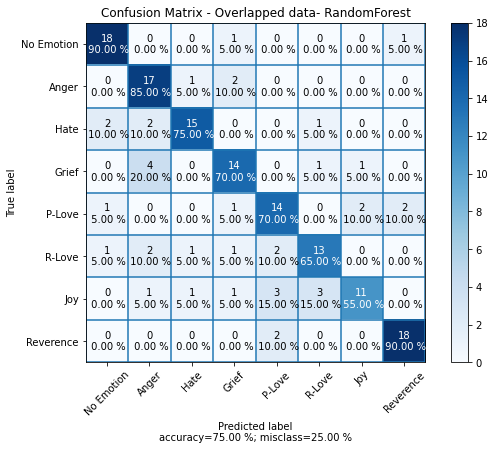

In [25]:
rfe_selector = RFE(estimator = RandomForestClassifier(), n_features_to_select = 15, step = 1)
# rfe_selector = RFE(estimator = RandomForestClassifier(random_state = 0, n_estimators = 500, max_depth = 20), n_features_to_select = 30, step = 1)
rfe_selector.fit(X_features_train, y_train)
rfe_support = rfe_selector.get_support()

# feat_cols = [i if rfe_support[i] is True for i in range(rfe_support.size)]
feat_cols = []
for i in range(rfe_support.size):
    if rfe_support[i]:
        feat_cols.append(i)
# [0, 1, 4, 5, 10, 14, 15, 18, 19, 20, 22, 26, 27, 28, 29, 31, 39, 40, 42] 0%
# [0, 1, 4, 5, 6, 10, 14, 15, 17, 18, 19, 20, 26, 27, 28, 29, 39, 40, 42] 10%
print(feat_cols)

X_train = X_features_train[:, feat_cols]
X_test = X_features_test[:, feat_cols]

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
CM = confusion_matrix(y_test, clf.predict(X_test))

fig = plot_confusion_matrix(cm  = CM,
                      normalize    = None,
                      target_names = emotion_keys,
                      title        = "Confusion Matrix - Overlapped data- RandomForest",
                      savefig = True,
                      figname = "Random Forest confusion matrix-both.png")

In [9]:
resDT = []
resLDA = []
for i in range(1, 53):
    rfe_selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = i, step = 1)
    rfe_selector.fit(X_features_train, y_train)
    rfe_support = rfe_selector.get_support()
    feat_cols = []
    for i in range(rfe_support.size):
        if rfe_support[i]:
            feat_cols.append(i)
    X_train = X_features_train[:, feat_cols]
    X_test = X_features_test[:, feat_cols]
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    resDT.append(clf.score(X_test, y_test))
    
    rfe_selector = RFE(estimator = LDA(), n_features_to_select = i, step = 1)
    rfe_selector.fit(X_features_train, y_train)
    rfe_support = rfe_selector.get_support()
    feat_cols = []
    for i in range(rfe_support.size):
        if rfe_support[i]:
            feat_cols.append(i)
    X_train = X_features_train[:, feat_cols]
    X_test = X_features_test[:, feat_cols]
    
    clf = LDA()
    clf.fit(X_train, y_train)
    resLDA.append(clf.score(X_test, y_test))
    
print("DT:", resDT)
print("LDA:", resLDA)

DT: [0.225, 0.43125, 0.54375, 0.475, 0.5, 0.5125, 0.5375, 0.525, 0.53125, 0.48125, 0.5625, 0.53125, 0.5625, 0.51875, 0.5625, 0.53125, 0.5375, 0.4875, 0.56875, 0.6, 0.5375, 0.525, 0.575, 0.525, 0.5625, 0.5125, 0.54375, 0.55625, 0.5875, 0.5125, 0.55625, 0.45625, 0.53125, 0.5625, 0.5, 0.5375, 0.5, 0.53125, 0.55625, 0.54375, 0.5625, 0.5125, 0.5375, 0.5, 0.5, 0.49375, 0.525, 0.5, 0.5, 0.46875, 0.50625, 0.50625]
LDA: [0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875, 0.46875]


In [73]:
feat_cols = [0, 1, 2, 4, 11, 14, 15, 16, 20, 22, 24, 26, 28, 29, 32, 40, 41, 42, 51]
X_train = X_features_train[:, feat_cols]
X_test = X_features_test[:, feat_cols]

## Choosing only best features
 take only best features set to feed to models

In [22]:
mode = 'Forward'

feat_cols = [0, 1, 3, 4, 5, 9, 14, 15, 16, 20, 26, 27, 28, 29, 39, 40, 41, 42, 48]
"""all 42 features after dropped correlation"""


"""---stratify split---"""
"""K nearest neighbors"""

# feat_cols = [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 19, 20, 30, 31, 33, 34, 43, 46, 47, 48, 51]

"""---random split---"""
"""K nearest neighbors"""

# feat_cols = [1, 2, 5, 6, 10, 14, 18, 19, 30, 33, 34, 45, 46, 51]
"""Naive Bayes"""
# fat_cols = [0, 1, 3, 7, 8, 11, 12, 14, 15, 19, 20, 24, 27, 28, 37, 38, 39, 40, 43, 46, 48, 50, 51] #21/52

"""----------------------------------------------SBFS-------------------------------------------"""
# mode = 'Backward'

# feat_cols = list(sfs_forward.k_feature_idx_)
# feat_cols = [0, 1, 2, 4, 5, 6, 9, 10, 11, 17, 19, 20, 22, 23, 26, 27, 28, 29, 35, 39, 40, 41, 42, 43, 47, 48, 49, 51]
X_train = X_features_train[:, feat_cols]
X_test = X_features_test[:, feat_cols]
# X_train = X_features_train
# X_test = X_features_test
n_features = X_train.shape[1]
print(n_features)

# X_test_original = X_test_original[:, feat_cols]

19


In [50]:
## grid search for SVM classifier
clf = SVC()

params_grid = {"kernel":["rbf"],
               "gamma": [1e-2, 1e-1, 3e-1, 5e-1, 7e-1],
               "C":[10, 100, 1000]}
gs = GridSearchCV(clf, param_grid = params_grid, scoring = "accuracy", cv = 10)
gs.fit(X_train, y_train)
for i in range(len(gs.cv_results_['params'])):
    print(gs.cv_results_['params'][i], 'test acc.:', gs.cv_results_['mean_test_score'][i])

print("Best parameters via GridSearch", gs.best_params_)
print(gs.cv_results_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.3345276209035953
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.2751600779510022
{'C': 10, 'gamma': 0.3, 'kernel': 'rbf'} test acc.: 0.25420527760101813
{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'} test acc.: 0.24237939468660516
{'C': 10, 'gamma': 0.7, 'kernel': 'rbf'} test acc.: 0.22898902322621698
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.32269030384982506
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.27227022351256763
{'C': 100, 'gamma': 0.3, 'kernel': 'rbf'} test acc.: 0.24595132039452752
{'C': 100, 'gamma': 0.5, 'kernel': 'rbf'} test acc.: 0.23947959751829467
{'C': 100, 'gamma': 0.7, 'kernel': 'rbf'} test acc.: 0.22474844893413937
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.2927959950684059
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.27271516067451473
{'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'} test acc.: 0.24639774896595612
{'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'} test acc.:

In [32]:
## save SVM grid search results
df = pd.DataFrame.from_dict(gs.cv_results_, orient="index")
df.head()
result_dir = os.path.join(root, results_fold)
if mode == 'Forward':
    csv_name = f'Classifier/stratify-split-SFFS-{total_features}-{n_features}-features-SVM-gridsearchcv.csv'
else:
    csv_name = f'Classifier/stratify-split-SBFS-{total_features}-{n_features}-features-SVM-gridsearchcv.csv'
print("SFAs mode: ", mode)
df.to_csv(os.path.join(result_dir, csv_name))

SFAs mode:  Forward


overlap 9
[1.e+02 2.e+02 3.e+02 4.e+02 5.e+02 6.e+02 7.e+02 8.e+02 9.e+02 1.e+03
 1.e-01 1.e+00 1.e+01 1.e+04]
Best res: [0.9125, 100.0, 0.8]
saved image to drive


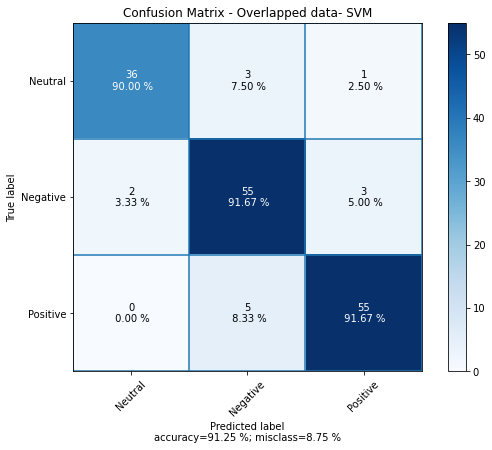

In [23]:
print("overlap", overlap)
C_param = np.arange(100, 1100, 100)
b = [0.1, 1, 10, 10000]
C_param = np.append(C_param, b)
print(C_param)
gamma_param = np.arange(0.1, 3.9, 0.1)
best_res = [0,0,0]

for C in C_param:
    for gamma in gamma_param:
        clf = SVC(kernel = 'rbf', C = C, gamma = gamma);
        clf.fit(X_train, y_train)
        temp = clf.score(X_test, y_test)
        if ( temp > best_res[0]):
            best_res = [temp, C, gamma]
print("Best res:", best_res)

clf = SVC(kernel = 'rbf', C = best_res[1], gamma = best_res[2])
# clf = SVC(kernel = 'rbf', C = 500, gamma = 0.1)

clf.fit(X_train, y_train)
CM = confusion_matrix(y_test, clf.predict(X_test))

key = ["Neutral", "Negative", "Positive"]

fig = plot_confusion_matrix(cm  = CM,
                      normalize    = None,
                      target_names = key,
                      title        = "Confusion Matrix - Overlapped data- SVM",
                      savefig = True,
                      figname = "SVM-overlapped-confusionmatrix - both.png")

# fig = plot_confusion_matrix(cm  = CM,
#                       normalize    = None,
#                       target_names = emotion_keys,
#                       title        = "Confusion Matrix - Overlapped data- SVM",
#                       savefig = True,
#                       figname = "SVM-overlapped-confusionmatrix - both.png")

In [35]:
# softmax classifier
clf = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial')

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

print(confusion_matrix(clf.predict(X_test), y_test))
# plot_confusion_matrix_from_data(y_test,clf.predict(X_test), columns=emotion_keys, title = clf,
#                                 savefig = True, fig_dir = fold_dir, figname = f"MODEL-softmax-{n_features}-{total_features}-all-features-cm-8-emotions.png")

# print(clf.score(X_test_original, y_test_original))

# plot_confusion_matrix_from_data(y_test_original, clf.predict(X_test_original), columns=emotion_keys, title = clf,
#                                 savefig = True, fig_dir = fold_dir, figname = f"MODEL-softmax-{n_features}-features-cm-8-emotions-original-data.png")

0.43240037950664134
0.43548387096774194
[[53  6 16 10 10  6  2  5]
 [ 4 60  3  9  0 10  8  0]
 [ 5  3 24 12  9  5  2  7]
 [ 7 15  8 29  4  5  9  3]
 [ 3  0 11  9 32  6  6 10]
 [ 3  3  5  7  6 31 17  4]
 [ 1  4  6  9  9 12 42 11]
 [17  2 20  8 23 18  7 53]]


c:\users\nam4.nguyen\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Try KNN classifier
clf = KNeighborsClassifier(n_neighbors= 1)

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))
print(confusion_matrix(clf.predict(X_test), y_test))


0.8166666666666667
[[52  1  4  1  0  0  2  0]
 [ 0 55  0  5  1  4  0  0]
 [ 4  1 48  0  1  7  1  0]
 [ 1  2  3 47  1  6  1  5]
 [ 3  0  3  3 53  6  2  1]
 [ 0  0  2  2  2 37  6  0]
 [ 0  1  0  0  0  0 48  2]
 [ 0  0  0  2  2  0  0 52]]


0.51875
[[ 9  2  4  1  2  0  1  1]
 [ 3 11  0  2  0  2  2  0]
 [ 3  0 12  1  1  0  1  2]
 [ 0  1  2 10  2  2  3  0]
 [ 0  0  1  2  9  1  2  5]
 [ 1  1  1  0  3 10  3  1]
 [ 0  1  1  0  4  3 10  1]
 [ 1  0  0  0  4  3  0 12]]


[Text(148.50830623601885, 212.49818181818182, 'X[4] <= -0.057\ngini = 0.875\nsamples = 1440\nvalue = [180, 180, 180, 180, 180, 180, 180, 180]'),
 Text(27.906619441431673, 202.61454545454546, 'X[6] <= -1.466\ngini = 0.813\nsamples = 523\nvalue = [111, 4, 85, 23, 75, 45, 30, 150]'),
 Text(3.6312364425162693, 192.73090909090908, 'X[11] <= 1.19\ngini = 0.241\nsamples = 38\nvalue = [33, 1, 1, 2, 1, 0, 0, 0]'),
 Text(2.1787418655097612, 182.84727272727272, 'X[4] <= -0.057\ngini = 0.109\nsamples = 35\nvalue = [33, 1, 0, 0, 1, 0, 0, 0]'),
 Text(1.4524945770065076, 172.96363636363637, 'X[8] <= -0.247\ngini = 0.057\nsamples = 34\nvalue = [33, 0, 0, 0, 1, 0, 0, 0]'),
 Text(0.7262472885032538, 163.07999999999998, 'gini = 0.0\nsamples = 31\nvalue = [31, 0, 0, 0, 0, 0, 0, 0]'),
 Text(2.1787418655097612, 163.07999999999998, 'X[11] <= -0.837\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 0, 0, 1, 0, 0, 0]'),
 Text(1.4524945770065076, 153.19636363636363, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1, 0,

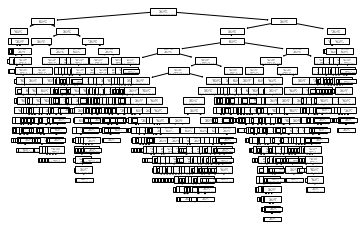

In [14]:
# Decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
CM = confusion_matrix(y_test, clf.predict(X_test))
print(clf.score(X_test, y_test))
print(CM)
plot_tree(clf)

# Random forest classifier


In [88]:
# search params for RF classifier using grid search
# Create the parameter grid 
param_grid = {
    'n_estimators'      : [64, 100, 200, 300, 400, 500, 600],
    'max_depth'         : [30, 40, 50, 100],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
gs.fit(X_train, y_train)   

for i in range(len(gs.cv_results_['params'])):
    print(gs.cv_results_['params'][i], 'test acc.:', gs.cv_results_['mean_test_score'][i])

print("Best parameters via GridSearch", gs.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'max_depth': 30, 'n_estimators': 64, 'random_state': 0} test acc.: 0.3536385511010665
{'max_depth': 30, 'n_estimators': 100, 'random_state': 0} test acc.: 0.35316714734670246
{'max_depth': 30, 'n_estimators': 200, 'random_state': 0} test acc.: 0.35719783216114864
{'max_depth': 30, 'n_estimators': 300, 'random_state': 0} test acc.: 0.3548250718209059
{'max_depth': 30, 'n_estimators': 400, 'random_state': 0} test acc.: 0.35506147644667824
{'max_depth': 30, 'n_estimators': 500, 'random_state': 0} test acc.: 0.3534021464752942
{'max_depth': 30, 'n_estimators': 600, 'random_state': 0} test acc.: 0.3560099059441287
{'max_depth': 40, 'n_estimators': 64, 'random_state': 0} test acc.: 0.3536385511010665
{'max_depth': 40, 'n_estimators': 100, 'random_state': 0} test acc.: 0.35316714734670246
{'max_depth': 40, 'n_estimators': 200, 'random_state': 0} test acc.: 0.35719783216114864
{'max_depth': 40, 'n_estimators': 300, 'random_state': 

In [0]:
# save gridsearch result
df = pd.DataFrame.from_dict(gs.cv_results_, orient="index")
df.head()
result_dir = os.path.join(root, results_fold)
csv_name = f'Classifier/stratify-split-{mode}-{total_features}-{n_features}-features-RF-gridsearchcv.csv'
df.to_csv(os.path.join(result_dir, csv_name))

overlap 9
Best res:  [0.925, 100, 30]
saved image to drive


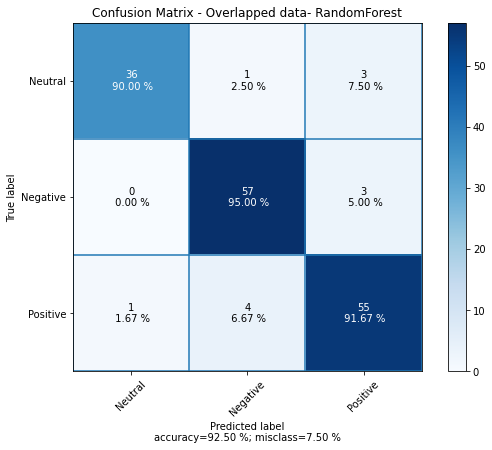

In [24]:
print("overlap", overlap)
n_param = np.arange(100, 1000, 100)
depth_param = np.arange(20, 150, 10)
best_res = [0,0,0]
for n in n_param:
    for depth in depth_param:
        clf = RandomForestClassifier(random_state = 0, n_estimators = n, max_depth = depth);
        clf.fit(X_train, y_train)
        temp = clf.score(X_test, y_test)
        if ( temp > best_res[0]):
            best_res = [temp, n, depth]
print("Best res: ", best_res)

clf = RandomForestClassifier(random_state = 0, n_estimators = best_res[1], max_depth = best_res[2])
# clf = RandomForestClassifier(random_state = 0, n_estimators = 400, max_depth = 20)
clf.fit(X_train, y_train)
CM = confusion_matrix(y_test, clf.predict(X_test))

fig = plot_confusion_matrix(cm  = CM,
                      normalize    = None,
                      target_names = key,
                      title        = "Confusion Matrix - Overlapped data- RandomForest",
                      savefig = True,
                      figname = "Random Forest confusion matrix-both.png")

# fig = plot_confusion_matrix(cm  = CM,
#                       normalize    = None,
#                       target_names = emotion_keys,
#                       title        = "Confusion Matrix - Overlapped data- RandomForest",
#                       savefig = True,
#                       figname = "Random Forest confusion matrix-both.png")

# Keras Tuner -- not necessary
- Tuning some Neural network 
- Retrain the network architecture after tuning

In [13]:
%tensorflow_version 2.x 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.tuners import Sklearn
from kerastuner.tuners import BayesianOptimization
from keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback

P_DIR = os.path.join(fold_dir, "Neural")

import datetime

def get_datetime():
    currentDT = datetime.datetime.now()
    date_time = currentDT.strftime("%Y/%m/%d") + "-" + currentDT.strftime("%H:%M:%S")

    return date_time
date_time = get_datetime()
print(date_time)

Using TensorFlow backend.


2020/05/31-05:31:19


## Random search no dropout

In [0]:
SEED_NUMBER  = 17
np.random.seed(SEED_NUMBER)
# learning_rate_range = 10**(-5*np.random.rand(10))
# print(learning_rate_range)

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=32,
                                            step=4),
                               activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model


EPOCHS = 1000
BATCH_SIZE = 64
date_time = get_datetime()
P_NAME = f"RandomSearch-{EPOCHS}-epoch-{date_time}"

tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=10,
    executions_per_trial=3,
    directory=P_DIR,
    project_name=P_NAME)

tuner.search_space_summary()


[3.36259828e-02 2.22364893e-03 1.10254434e-01 4.57612848e-01
 1.16164305e-04 5.22796163e-04 6.49225426e-04 1.32429741e-03
 6.37801328e-01 1.62529417e-02]


In [0]:



tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size = BATCH_SIZE,
             validation_data = (X_test, y_test),
            # validation_split = 0.1,
             shuffle = True,
             verbose = 0)



INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)
import pickle
with open(os.path.join(P_DIR, P_NAME, f"RandomSearch_{EPOCHS}.pkl"), "wb") as f:
    pickle.dump(tuner, f)



In [0]:
b_model = tuner.get_best_models(num_models=1)[0]
print(b_model.evaluate(X_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
744/744 [==============================] - 8s 10ms/sample - loss: 0.3832 - acc: 0.9301
[0.38324652848544943, 0.93010753]


## Random search drop-out

In [0]:


def tune_dropout_model(hp):
    model = keras.Sequential()


    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=32,
                                            step=4),
                               activation='relu'))
        model.add(keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))

    model.add(layers.Dense(8, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [0]:
EPOCHS = 10000
BATCH_SIZE = 128
date_time = get_datetime()
P_NAME = f"RandomSearch-{EPOCHS}-epoch-{date_time}"
tuner = RandomSearch(
    tune_dropout_model,
    objective='val_acc',
    max_trials=10,
    executions_per_trial=5,
    directory=P_DIR,
    project_name=P_NAME)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000, restore_best_weights=True)

tuner.search_space_summary()


In [0]:
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size = BATCH_SIZE,
             validation_data = (X_test, y_test),
             callbacks = [es],
            # validation_split = 0.1,
             shuffle = True,
             verbose = 0)

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Restoring model weights from the end of the best epoch
Epoch 07368: early stopping
Restoring model weights from the end of the best epoch
Epoch 09796: early stopping


Restoring model weights from the end of the best epoch
Epoch 05415: early stopping


KeyboardInterrupt: ignored

In [0]:

# print(best_hyperparameters)
# import pickle
# with open(os.path.join(P_DIR, P_NAME, f"RandomSearch-Dropout_{EPOCHS}.pkl"), "wb") as f:
#     pickle.dump(tuner, f)

## HyperBand search

In [0]:
def tune_dropout_model(hp):
    model = keras.Model()

    inputs = keras.Input(shape=(X_train.shape[1]))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 5)):
        x = layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=16,
                                            max_value=64,
                                            step=16),
                               activation='relu')(x)
        x = keras.layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1, default=0.2))(x)

    outputs = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [0]:
# date_time = get_datetime()

EPOCHS = 10000
BATCH_SIZE = 256
P_NAME = f"Hyperband-DropOut-max-{EPOCHS}-epochs"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, restore_best_weights=True)

tuner = Hyperband(
    tune_dropout_model,
    objective = "val_accuracy",
    max_epochs = EPOCHS,
    directory = P_DIR,
    project_name = P_NAME
)
tuner.search_space_summary()


INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Projects/Emotion Recognition/neural setA/results/8s-overlapping/Neural/Hyperband-DropOut-max-10000-epochs/tuner0.json


UnknownError: ignored

In [0]:

tuner.search(X_train, y_train,
            #  batch_size = BATCH_SIZE,
             validation_data = (X_test, y_test),
            # validation_split = 0.1,   
             callbacks = [es],
             shuffle = True,
             verbose = 0)




In [0]:
tuner.results_summary()
models = tuner.get_best_models(num_models=3)
for i, model in enumerate(models):
    model.save(os.path.join(P_DIR, P_NAME, f"HyperBand_{EPOCHS}-{i}.h5"))
tuner.save_model(models)

In [0]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)

with open(os.path.join(P_DIR, P_NAME, f"HyperBand_{EPOCHS}.pkl"), "wb") as f:
    pickle.dump(tuner, f)
    print("saved tuner to pickle")

In [0]:
print(os.path.join(P_DIR, P_NAME, f"HyperBand_{EPOCHS}.pkl"))
with open(os.path.join(P_DIR, P_NAME, f"HyperBand_{EPOCHS}.pkl"), "rb") as f:
    tuner = pickle.load(f)

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)

/content/drive/My Drive/Projects/Emotion Recognition/neural setA/results/8s-overlapping/Neural/Hyperband-DropOut-max-500-epochs-2020/03/21-13:34:40/HyperBand_500.pkl


EOFError: ignored

## Bayesian optimization

In [2]:
def tune_dropout_model(hp):
    model = keras.Model()

    inputs = keras.Input(shape=(X_train.shape[1]))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 5)):
        x = layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=16,
                                            max_value=128,
                                            step=16),
                               activation='relu')(x)
        x = keras.layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1, default=0.2))(x)

    outputs = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs, outputs)
    # learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    learning_rate = 5e-3
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['acc'])

    return model

def two_layers_tune_dropout_model(hp):
    model = keras.Model()

    inputs = keras.Input(shape=(X_train.shape[1]))
    x = inputs
    x = layers.Dense(units=hp.Int('units_1',
                                        min_value=16,
                                        max_value=128,
                                        step=16),
                            activation='relu')(x)
    x = keras.layers.Dropout(hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.2))(x)
    x = layers.Dense(units=hp.Int('units_2',
                                        min_value=16,
                                        max_value=128,
                                        step=16),
                            activation='relu')(x)
    x = keras.layers.Dropout(hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.2))(x)

    outputs = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs, outputs)

    # learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    learning_rate = 4e-3
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['acc'])

    return model

In [3]:
tune_2_layers = False
if tune_2_layers:
    n_layers = 2
    model_to_tune = two_layers_tune_dropout_model
    print("tunning 2 layers model")

else:
    n_layers = 'multi'
    model_to_tune = tune_dropout_model
    print("tunning multilayers model")


EPOCHS = 20000
BATCH_SIZE = 128

P_NAME = f"BayesianOptimization-DropOut-{EPOCHS}-epochs-{n_layers}-layers-{BATCH_SIZE}-batchsize"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, restore_best_weights=True)

tuner = BayesianOptimization(
    model_to_tune,
    objective = "val_acc",
    max_trials = 20,
    executions_per_trial = 10,
    directory = P_DIR,
    project_name = P_NAME

)


tunning multilayers model


NameError: name 'EarlyStopping' is not defined

In [16]:

# start searching
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size = BATCH_SIZE,
            #  validation_data = (X_test, y_test),
             callbacks = [es],
             validation_split = 0.1,
             shuffle = True,
             verbose = 0)

# check out the results 
tuner.results_summary()

best_models = tuner.get_best_models(10)
for i, model in enumerate(best_models):
    model.save(os.path.join(P_DIR,P_NAME, f"model_2layers_retrained_{i}.h5" ))
    loss, accuracy = model.evaluate(X_test, y_test)

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)



Restoring model weights from the end of the best epoch.
Epoch 01821: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01818: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03294: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02971: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02386: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02854: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03016: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02870: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02894: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02524: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01495: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02576: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02554: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02673: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01955: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01895: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03718: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02334: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03562: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01828: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00864: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00712: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00720: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00700: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00710: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01000: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00664: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00721: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00914: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00818: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00537: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00541: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00552: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00576: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00550: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00553: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00553: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00576: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01058: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00558: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01239: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01549: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02101: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01173: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01956: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00861: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02354: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01995: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01470: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01387: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00935: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00988: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01491: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02102: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02096: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00975: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01680: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01510: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01264: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01116: early stopping


Restoring model weights from the end of the best epoch.
Epoch 03302: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01742: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02266: early stopping
Restoring model weights from the end of the best epoch.
Epoch 04217: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03211: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02400: early stopping
Restoring model weights from the end of the best epoch.
Epoch 04940: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02771: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03326: early stopping
Restoring model weights from the end of the best epoch.
Epoch 03822: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00586: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00579: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00648: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00566: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00553: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00546: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00548: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00566: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00558: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00557: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00570: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00555: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00552: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00535: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00554: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00531: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00613: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00566: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00588: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00597: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01391: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01639: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00924: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01253: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01417: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02319: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02199: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01082: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01702: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01201: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01651: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02492: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01856: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00788: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01074: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01539: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01423: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01874: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01141: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01488: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01463: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01731: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00914: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02523: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02890: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02079: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01265: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00930: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01162: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02573: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01823: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01633: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01700: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01697: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02045: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02184: early stopping
Restoring model weights from the end of the best epoch.
Epoch 04151: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02519: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02250: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01587: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01672: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02191: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00935: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02659: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01226: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01463: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02403: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00846: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01968: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01851: early stopping


Restoring model weights from the end of the best epoch.
Epoch 02297: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01189: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01223: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01822: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02725: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01203: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02104: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01991: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01102: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02812: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01961: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01153: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02231: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01288: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02317: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01616: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02344: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02107: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01133: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01734: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01421: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02387: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02036: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00826: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01206: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01357: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01386: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01046: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01988: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01877: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01582: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01282: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01973: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01786: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02144: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01524: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00986: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02282: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01059: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01275: early stopping


Restoring model weights from the end of the best epoch.
Epoch 01482: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01965: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01457: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01905: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01076: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01411: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01037: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01660: early stopping
Restoring model weights from the end of the best epoch.
Epoch 02603: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01872: early stopping


Restoring model weights from the end of the best epoch.
Epoch 00842: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01129: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00878: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00730: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00821: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00966: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00836: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00782: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00820: early stopping
Restoring model weights from the end of the best epoch.
Epoch 01266: early stopping


INFO:tensorflow:Oracle triggered exit


24/24 [==============================] - 0s 2ms/step - loss: 0.2836 - acc: 0.8978


In [18]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 20,104
Trainable params: 20,104
Non-trainable params: 0
_______________________________________________________

In [17]:
best_models = tuner.get_best_models(5)
from keras.utils import plot_model
for i, model in enumerate(best_models):
    # model.save(os.path.join(P_DIR,P_NAME, f"model_2layers_{i}.h5" ))
    # plot_model(model, to_file= os.path.join(P_DIR,P_NAME,f'model_{i}.png'))

    print(model.evaluate(X_test, y_test))
    print(model.summary())
# summary = tuner.results_summary()

# print(summary)

24/24 [==============================] - 0s 2ms/step - loss: 0.2777 - acc: 0.8992
[0.27773317694664, 0.899193525314331]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total

In [0]:
print(y_test)

[0. 7. 6. 7. 7. 1. 7. 0. 2. 4. 6. 6. 4. 1. 6. 5. 1. 0. 0. 5. 1. 2. 5. 1.
 7. 6. 3. 7. 7. 0. 5. 6. 0. 0. 6. 4. 2. 0. 2. 4. 7. 1. 7. 1. 2. 5. 4. 1.
 4. 2. 0. 6. 2. 7. 4. 3. 6. 6. 1. 3. 6. 4. 7. 6. 4. 1. 5. 7. 4. 0. 7. 5.
 2. 1. 1. 6. 4. 1. 6. 7. 3. 0. 3. 2. 4. 2. 1. 4. 3. 0. 3. 5. 1. 6. 2. 7.
 1. 5. 4. 4. 5. 1. 2. 7. 0. 5. 2. 7. 4. 6. 4. 6. 4. 5. 4. 5. 5. 3. 3. 6.
 2. 5. 3. 5. 5. 3. 1. 2. 1. 7. 7. 7. 3. 1. 4. 0. 3. 7. 4. 0. 4. 4. 6. 4.
 0. 7. 6. 4. 2. 4. 3. 1. 7. 7. 2. 4. 4. 6. 7. 2. 0. 0. 4. 2. 2. 6. 1. 4.
 0. 2. 7. 2. 3. 1. 6. 1. 6. 3. 7. 0. 4. 1. 2. 4. 1. 1. 1. 1. 3. 3. 7. 4.
 6. 6. 3. 6. 4. 4. 7. 2. 2. 2. 4. 1. 7. 2. 5. 3. 5. 5. 6. 4. 7. 4. 7. 5.
 1. 7. 3. 5. 0. 2. 3. 2. 1. 7. 3. 0. 6. 1. 5. 5. 6. 6. 3. 1. 5. 5. 3. 3.
 0. 2. 4. 2. 6. 3. 3. 3. 4. 0. 3. 4. 2. 3. 3. 6. 6. 3. 0. 7. 0. 5. 6. 7.
 2. 6. 1. 0. 3. 3. 6. 0. 7. 1. 6. 5. 2. 1. 1. 4. 7. 2. 5. 4. 1. 0. 5. 1.
 6. 5. 1. 1. 2. 3. 3. 1. 7. 3. 7. 5. 3. 5. 7. 7. 3. 2. 2. 0. 1. 3. 3. 3.
 7. 0. 4. 2. 7. 1. 3. 6. 2. 1. 5. 5. 4. 5. 1. 0. 5.

In [0]:
import pickle
with open(os.path.join(P_DIR, P_NAME, f"BayesianOptimization_{EPOCHS}.pkl"), "wb") as f:
    pickle.dump(tuner, f)

In [0]:
print(os.path.join(P_DIR, P_NAME, f"BayesianOptimization_{EPOCHS}.pkl"))
with open(os.path.join(P_DIR, P_NAME, f"BayesianOptimization_{EPOCHS}.pkl"), "rb") as f:
    tuner = pickle.load(f)

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)
loss, accuracy = best_model.evaluate(X_test, y_test)


/content/drive/My Drive/Projects/Emotion Recognition/neural setA/results/8s-overlapping/Neural/BayesianOptimization-DropOut-20000-epochs-2020/03/25-06:49:46/BayesianOptimization_20000.pkl


FileNotFoundError: ignored

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                10320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 648       
Total params: 13,528
Trainable params: 13,528
Non-trainable params: 0
_______________________________________________________

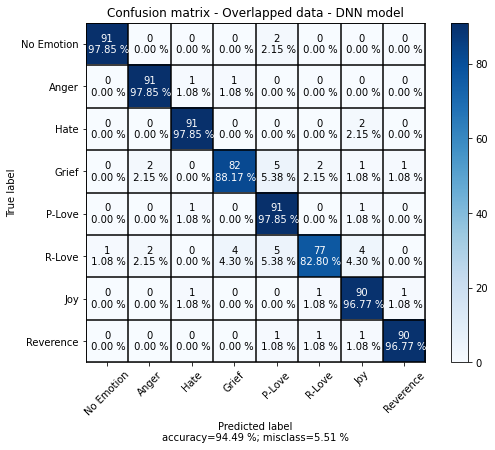

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 20,104
Trainable params: 20,104
Non-trainable params: 0
_______________________________________________________

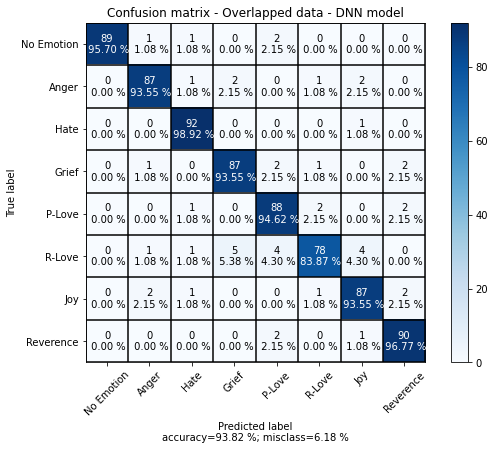

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 20,104
Trainable params: 20,104
Non-trainable params: 0
_______________________________________________________

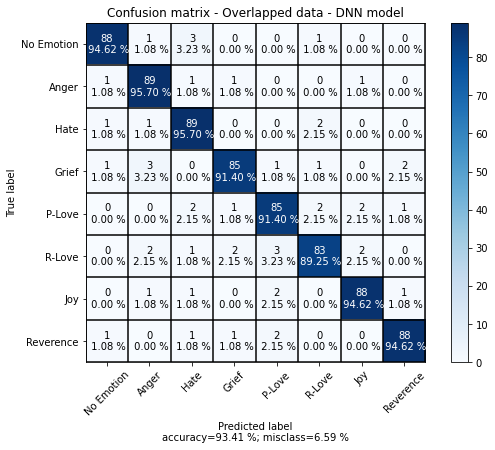

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 20,104
Trainable params: 20,104
Non-trainable params: 0
_______________________________________________________

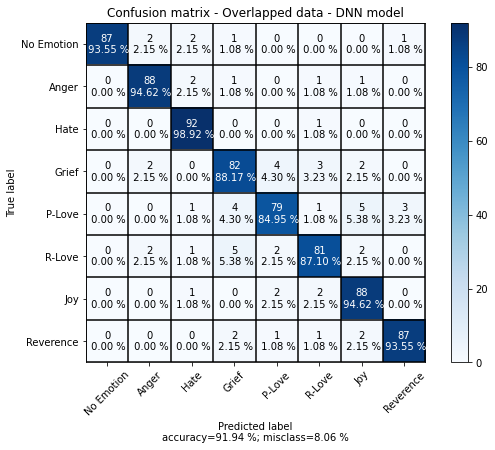

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                7760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 648       
Total params: 10,328
Trainable params: 10,328
Non-trainable params: 0
_______________________________________________________

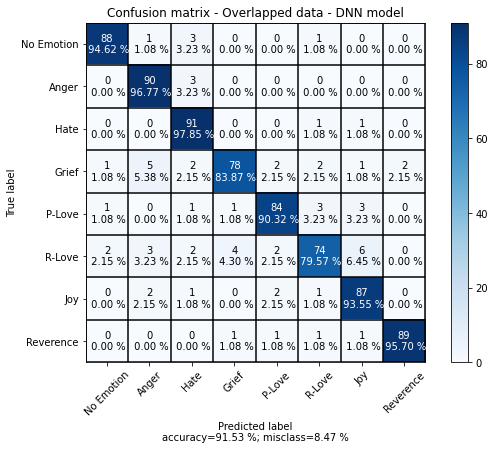

In [0]:
for i in range(5):
    # best_model =  keras.models.load_model(os.path.join(P_DIR,P_NAME, f"model_2layers_{i}.h5" ))
    best_model = best_models[i]
    best_model.summary()
    y_pred = best_model.predict(X_test)
    y_pred_ = np.argmax(y_pred, axis = 1)
    # y_test_ = np.argmax(y_test, axis = 1)
    print(y_pred_)
    CM = confusion_matrix(y_test, y_pred_)
    plot_confusion_matrix(CM,
                        target_names = emotion_keys,
                        normalize = None,
                        title = "Confusion matrix - Overlapped data - DNN model",
                        savefig = True,
                        figname = f'Bayesian optimization best model - {i}.png')

# Neural network

In [0]:
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# print(y_train)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
print(X_train.shape)
print(X_test.shape)

(4216, 19)
(744, 19)


In [0]:
def create_model(layers_dim, dropouts, learning_rate = 2e-4, decay = 0, input_dim = 19):
  model = Sequential()
  i = 0
  for dim, dropout_ratio in zip(layers_dim, dropouts):
    model.add(Dense(dim, input_dim = input_dim, name = f'Dense_{i}'))
    model.add(Activation('relu', name = f'Activation_{i}'))
    if dropout_ratio !=0.0:
        model.add(Dropout(dropout_ratio, name = f'Dropout_{i}'))
    i +=1


  model.add(Dense(8, activation = 'softmax', name = f"Dense_{i}"))
#   model.add(Activation('softmax'))

  opt = Adam(learning_rate = learning_rate, decay =decay)
  model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

  return model

In [0]:
# Trial summary
# |-Trial ID: 2c6e5a62f8bdb885458efa2934874391
# |-Score: 0.9399641553560892
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.2
# |-dropout_2: 0.0
# |-learning_rate: 0.0013279255909311328
# |-units_1: 128
# |-units_2: 80
# Trial summary
# |-Trial ID: 66bce5eab33ce09226822b659fdf7106
# |-Score: 0.9332437316576639
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.0
# |-learning_rate: 0.01
# |-units_1: 128
# |-units_2: 128
# Trial summary
# |-Trial ID: 099bb56b5fc1bee7c545a9fdec5c8048
# |-Score: 0.9305555621782938
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.30000000000000004
# |-learning_rate: 0.0021197272274267776
# |-units_1: 128
# |-units_2: 128
# Trial summary
# |-Trial ID: 85696ec1ca9296a8bf91eb7bdbe5ed4f
# |-Score: 0.9139784971872965
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.5
# |-learning_rate: 0.0001
# |-units_1: 128
# |-units_2: 128
# Trial summary
# |-Trial ID: 23fe70242367ccab8517aff0548b47a2
# |-Score: 0.9121864040692648
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.0
# |-learning_rate: 0.001198987260802545
# |-units_1: 96
# |-units_2: 80
# Trial summary
# |-Trial ID: 8723c9ad31b80f4b18d2435c93d3d914
# |-Score: 0.9112903475761414
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.30000000000000004
# |-dropout_2: 0.5
# |-learning_rate: 0.01
# |-units_1: 128
# |-units_2: 128
# Trial summary
# |-Trial ID: 26db8930f62c2cb03a9fb27f27bcbe7d
# |-Score: 0.9027777512868246
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.2
# |-dropout_2: 0.2
# |-learning_rate: 0.0009083541784678265
# |-units_1: 64
# |-units_2: 80
# Trial summary
# |-Trial ID: bac77018fbc4ee9a50af9d731b86395e
# |-Score: 0.9014337062835693
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.0
# |-learning_rate: 0.01
# |-units_1: 128
# |-units_2: 16
# Trial summary
# |-Trial ID: 8e97d708570481564987526239121adc
# |-Score: 0.9009856383005778
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.0
# |-learning_rate: 0.0001
# |-units_1: 128
# |-units_2: 128
# Trial summary
# |-Trial ID: 3ebae01042dd8b014d0262e047eb3ad5
# |-Score: 0.8982974688212076
# |-Best step: 0
# Hyperparameters:
# |-dropout_1: 0.0
# |-dropout_2: 0.5
# |-learning_rate: 0.01
# |-units_1: 128
# |-units_2: 64
# None
# layers_dim = [128, 80]
# dropouts = [0.2, 0.0]

layers_dim = [128, 80]
dropouts = [0.2, 0.0]
# learning_rate = 3e-4
learning_rate = 1e-2

iters = 10
loss_list = []
acc_list = []
for i in range(iters):
    print("iteration :", i)
    model = create_model(layers_dim, dropouts, learning_rate=learning_rate, input_dim=X_train.shape[-1])
    model.summary()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, restore_best_weights=True)
    # break
    H = model.fit(X_train, y_train,
                batch_size =128,
                epochs = 10000,
                #   validation_split =1/10,
                validation_data=(X_test, y_test),
                shuffle = True,
                verbose = 0,
                callbacks = [es]
                )
    loss_list.append(H.history['val_loss'])
    acc_list.append(H.history['val_accuracy'])
    print("==================================next iter=================================================")

iteration : 0
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 128)               2560      
_________________________________________________________________
Activation_0 (Activation)    (None, 128)               0         
_________________________________________________________________
Dropout_0 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 80)                10320     
_________________________________________________________________
Activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 8)                 648       
Total params: 13,528
Trainable params: 13,528
Non-trainable params: 0
___________________________________

In [0]:
# print(loss_list)
# print(acc_list)
loss_list = np.array(loss_list)
acc_list = np.array(acc_list)

print(loss_list.shape)
print(acc_list.shape)
np.save("nonDropout_loss_list.npy", loss_list)
np.save("nonDropout_acc_list.npy", acc_list)

(10,)
(10,)


In [0]:
print(np.mean([np.max(acc_list[i], axis = 0) for i in range(10)]))
print(np.mean([np.min(loss_list[i], axis = 0) for i in range(10)]))

0.9294354915618896
0.26054979860782623


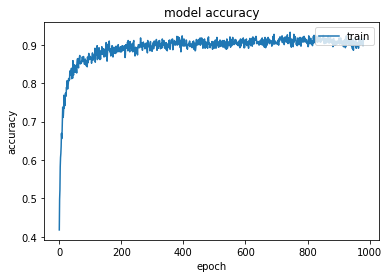

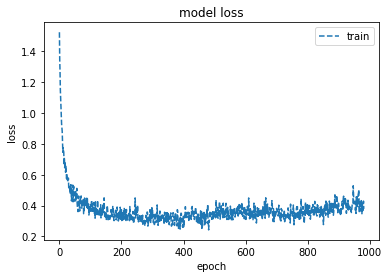

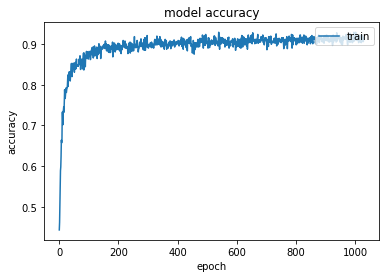

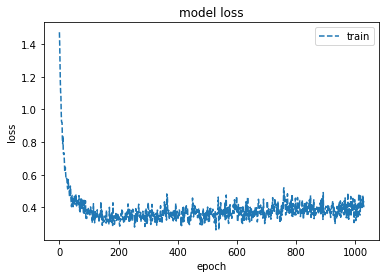

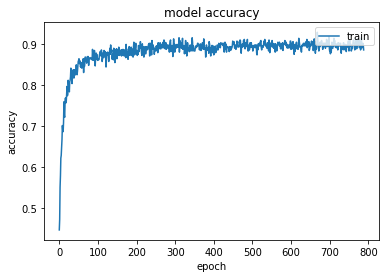

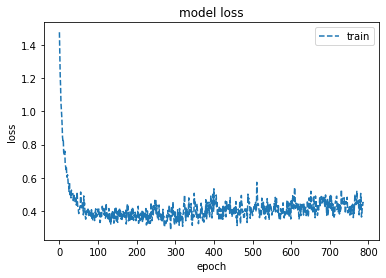

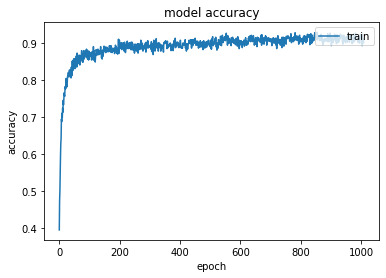

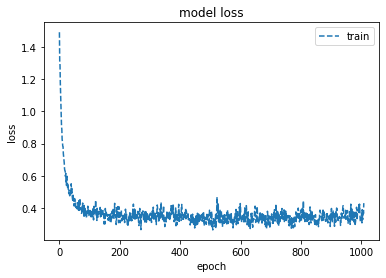

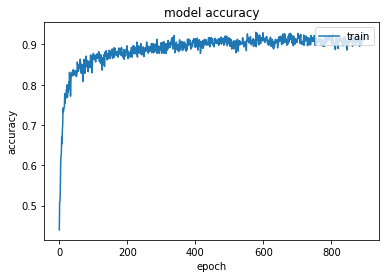

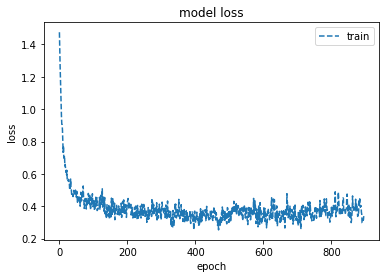

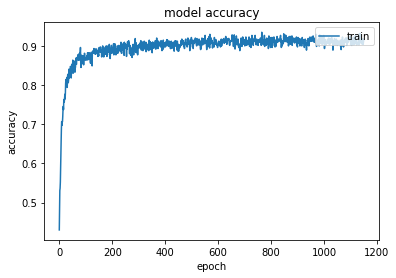

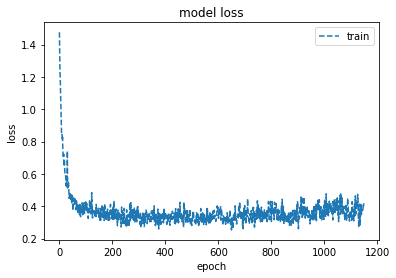

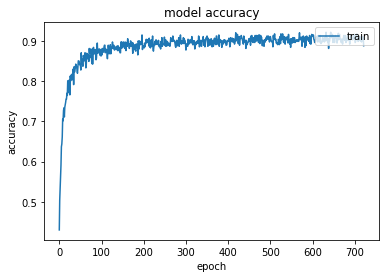

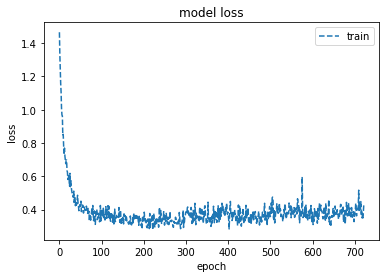

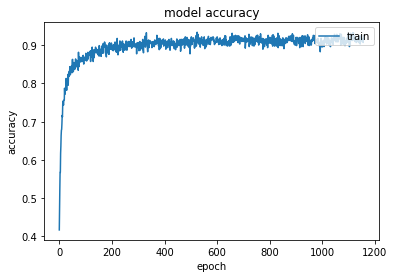

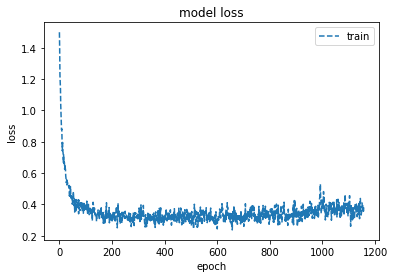

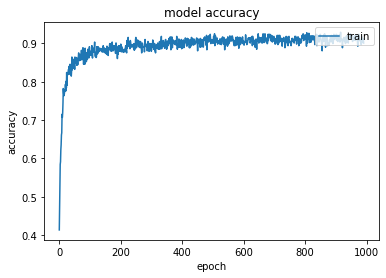

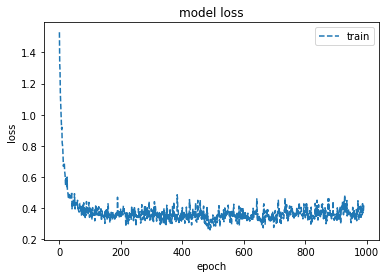

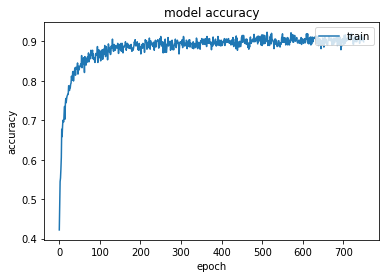

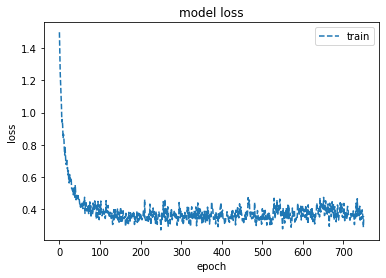

In [0]:
for i in range(10):
    plt.plot(acc_list[i])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    plt.plot(loss_list[i], linestyle='dashed')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [0]:
model.evaluate(X_test, y_test)
# model.evaluate(X_test_original, to_categorical(y_test_original))

24/24 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9315


[0.21794266998767853, 0.9314516186714172]

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True,  show_layer_names= True, rankdir='TB',  to_file='O_model.png')
# from IPython.display import SVG
# from tensorflow.keras.utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))


24/24 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9315
[0.21794266998767853, 0.9314516186714172]


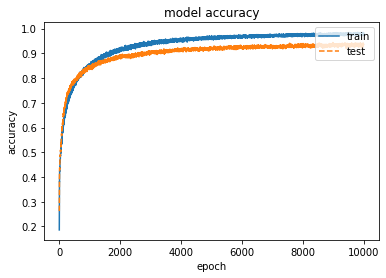

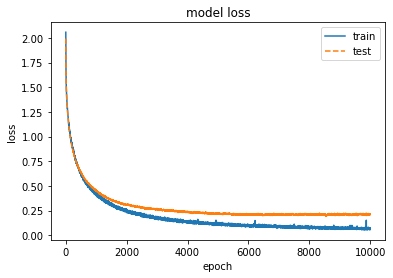

In [0]:
print(model.evaluate(X_test, y_test))
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'], linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'], linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

[0 6 6 7 7 6 7 0 2 2 6 6 4 1 5 5 1 0 2 5 1 2 5 1 7 6 3 7 7 0 5 6 0 0 6 4 2
 0 2 4 7 1 7 1 2 5 4 1 4 2 0 6 2 7 4 3 6 6 1 3 6 4 7 6 4 1 5 7 4 0 7 5 2 1
 1 6 4 1 6 7 3 0 3 2 4 2 1 4 4 0 3 5 1 6 2 7 1 6 4 7 5 1 2 7 0 5 2 7 7 6 4
 6 4 5 4 5 5 3 4 6 2 5 3 5 5 3 3 2 1 7 7 7 3 1 5 0 3 7 4 0 4 6 6 4 0 7 7 4
 2 4 3 1 7 7 2 4 4 6 7 2 0 0 4 2 2 6 1 4 0 2 7 2 3 1 6 1 6 3 7 0 4 1 2 4 1
 1 1 1 3 3 7 4 6 6 3 6 4 4 7 2 2 2 4 1 7 2 3 3 5 5 6 4 7 4 7 5 1 7 3 5 0 2
 3 2 1 7 3 0 6 1 5 4 6 6 3 1 5 5 3 3 0 2 4 2 6 3 3 3 4 0 3 4 2 3 3 6 6 3 0
 7 0 5 6 7 2 6 1 0 3 3 6 0 7 1 6 5 2 1 1 4 7 2 5 5 1 0 3 1 6 5 1 1 2 3 3 1
 7 3 7 5 3 5 7 7 3 2 2 0 1 3 3 3 4 0 4 2 7 1 3 6 2 6 5 5 4 5 1 0 5 0 0 2 3
 4 1 6 3 7 3 1 1 5 4 6 6 6 4 5 6 3 7 3 3 5 5 7 2 2 5 6 1 7 0 4 5 2 2 6 7 6
 2 0 1 5 2 2 0 7 2 1 1 7 5 3 5 0 3 0 1 3 0 5 4 1 4 1 2 3 1 6 3 0 3 5 3 5 6
 7 2 5 3 1 7 0 4 3 5 0 0 0 0 6 2 2 3 2 5 0 7 4 6 3 7 0 2 0 3 3 6 5 2 0 5 7
 6 5 7 4 1 7 1 4 5 4 7 4 5 4 6 1 7 4 5 6 3 7 2 5 6 7 3 1 0 3 6 6 2 4 2 7 6
 4 7 3 6 5 7 5 6 4 3 7 7 

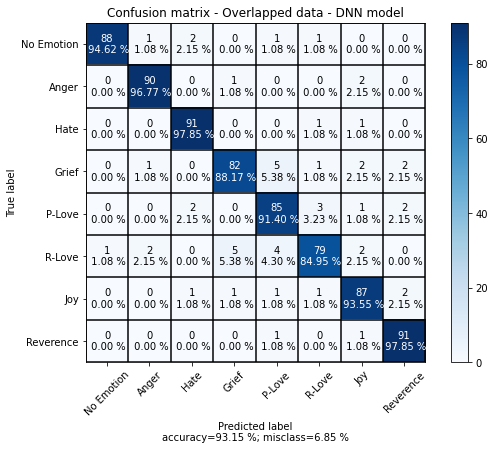

In [0]:
y_pred = model.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
# y_test_ = np.argmax(y_test, axis = 1)
print(y_pred_)
CM = confusion_matrix(y_test, y_pred_)
plot_confusion_matrix(CM,
                    target_names = emotion_keys,
                    normalize = None,
                    title = "Confusion matrix - Overlapped data - DNN model",
                    savefig = True,
                    figname = f'Bayesian optimization best model overlapped - {layers_dim} - {dropouts}.png')

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(confusion_matrix(y_pred, y_test_number))
print(accuracy_score(y_pred, y_test_number))
# plot_confusion_matrix_from_data(np.argmax(y_test, axis = 1),np.argmax(model.predict(X_test), axis = 1), columns=emotion_keys, 
#                                 savefig = True, fig_dir = fold_dir, figname = f"Neural-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-dropout-lr-{learning_rate}-cm-8-emotions.png")

# plot_confusion_matrix_from_data(y_test_original,np.argmax(model.predict(X_test_original), axis = 1), columns=emotion_keys, 
#                                 savefig = True, fig_dir = fold_dir, figname = f"Neural-{layers_dim}-{dropouts}-dropout-{n_features}-features-original-data-cm-8-emotions.png")

In [0]:
H.history.keys()

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join(fold_dir, f"MODEL-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-lr-{learning_rate}-accuracy_{X_test.shape[1]}_features.png"))


In [0]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join(fold_dir, f"MODEL-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-lr-{learning_rate}-loss_{X_test.shape[1]}_features.png"))

# train best neural network

In [0]:
def create_model(layers_dim, dropouts, learning_rate = 2e-4, decay = 0, input_dim = 20):
  model = Sequential()
  for dim, dropout_ratio in zip(layers_dim, dropouts):
    model.add(Dense(dim, input_dim = input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_ratio))


  model.add(Dense(8))
  model.add(Activation('softmax'))

  opt = Adam(learning_rate = learning_rate, decay =decay)
  model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

  return model

In [0]:
# |-dropout: 0.0
# |-learning_rate: 0.01
# |-num_layers: 5
# |-units_0: 64
# |-units_1: 64
# |-units_2: 64
# |-units_3: 16
# |-units_4: 16


# layers_dim = [128, 80]
# dropouts = [0.2, 0.0]

layers_dim = [102, 80]
dropouts = [0.0, 0.0]
learning_rate = 3e-4


model = create_model(layers_dim, dropouts, learning_rate=learning_rate, input_dim=X_train.shape[-1])
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
# break
H = model.fit(X_train, y_train,
            batch_size =128,
            epochs = 20000,
            #   validation_split =1/10,
            validation_data=(X_test, y_test),
            shuffle = True,
            verbose = 0,
            callbacks = [es]
            )


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 102)               2040      
_________________________________________________________________
Activation_0 (Activation)    (None, 102)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 80)                8240      
_________________________________________________________________
Activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 8)                 648       
Total params: 10,928
Trainable params: 10,928
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 01965: early stopping


In [0]:
print(model.evaluate(X_test, y_test))
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'], linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'], linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()